# Set up

## Dependencies

In [10]:
from io import BytesIO
from pdf2image import convert_from_path
from os import listdir, makedirs
from os.path import isfile, join
from tqdm import tqdm
from glob import glob
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import math
import copy
import r

## Constants

In [11]:
PDF_PATH = "../dataset/pdf"
IMAGE_PATH = "../dataset/image"

# Set plot size
plt.rcParams["figure.figsize"] = 15, 15

# Image Import

## Conversion from PDF to PNG (optional)

In [6]:
for filepath in tqdm(listdir(PDF_PATH)):
    images = convert_from_path(''.join([PDF_PATH, '/', filepath]))
    filename = filepath.split('.')[0]
    makedirs(''.join([IMAGE_PATH, '/', filename]))
    for index, image in enumerate(images):
        image.save(''.join([IMAGE_PATH, '/', filename, '/', str(index), '.png']), 'PNG')


  0%|          | 0/132 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Importing PNG

In [14]:
filenames = glob(''.join([IMAGE_PATH, '/*/*.png']))
filenames.sort()
# image = cv.imread(filenames[331], cv.IMREAD_GRAYSCALE)
image = cv.imdecode(np.fromstring(request.files['file'].read(), np.uint8), cv.IMREAD_UNCHANGED)
# file 231 fails bernsen
# For converting bgr to rgb for matplotlib show
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

NameError: name 'request' is not defined

## Binarization (Otsu Method)

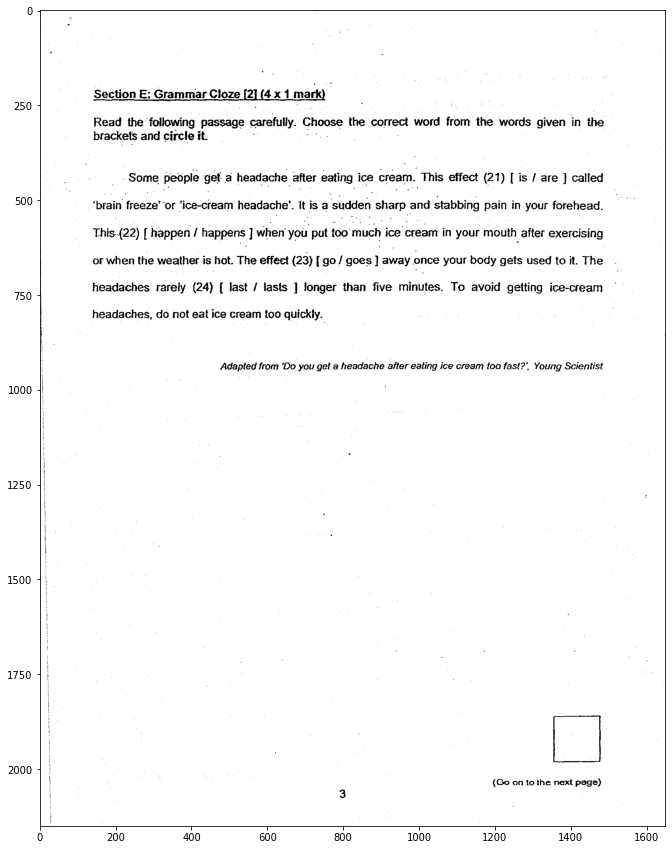

In [200]:
threshold, binarized = cv.threshold(image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
plt.imshow(cv.cvtColor(binarized, cv.COLOR_BGR2RGB))

## Binarization (Bernsen Method)

Threshold Value: 173.0


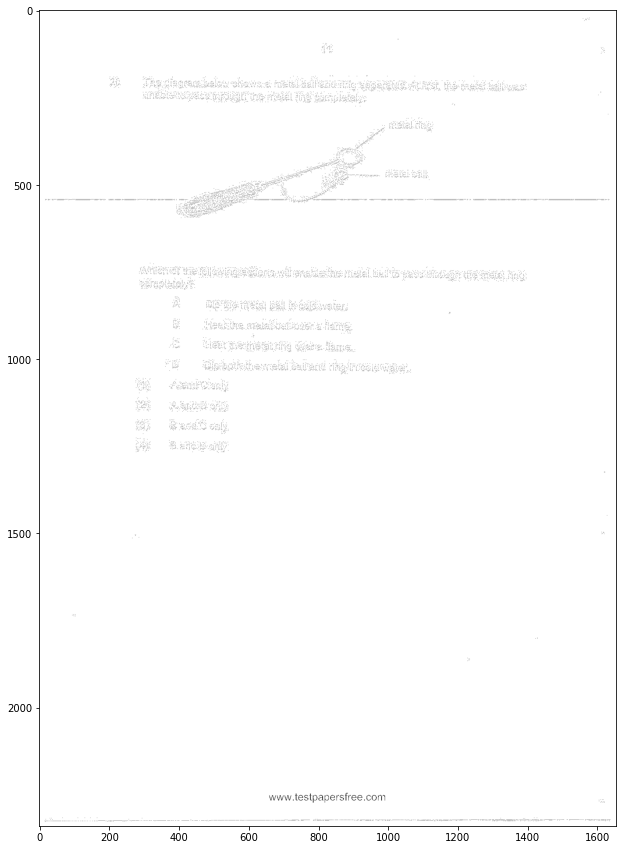

In [5]:
aperture_size = 3
contrast_limit = 10

offset = int(aperture_size / 2)
global_threshold = cv.threshold(image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[0]
print(f'Threshold Value: {global_threshold}')
not_image = cv.bitwise_not(image)
x, y = not_image.nonzero()
vals = image[x, y]
coors = tuple([x, y] for x, y in zip(x, y))
for coor in coors:
    aperture = np.copy(not_image[coor[0] - offset : coor[0] + offset + 1, coor[1] - offset : coor[1] + offset + 1])
    if aperture.size != 0: #
        contrast = abs(aperture.max() - aperture.min())
        if contrast > contrast_limit:
            threshold = int(aperture.max() + aperture.min() / 2)
        else: 
            threshold = global_threshold
        not_image[coor[0], coor[1]] = 0 if not_image[coor[0], coor[1]] < threshold else 255
    
plt.imshow(cv.cvtColor(cv.bitwise_not(not_image), cv.COLOR_BGR2RGB))

## Skew correction (Hough Transform)

Number of lines: 106
Deskew Angle: 0.03809466447664725


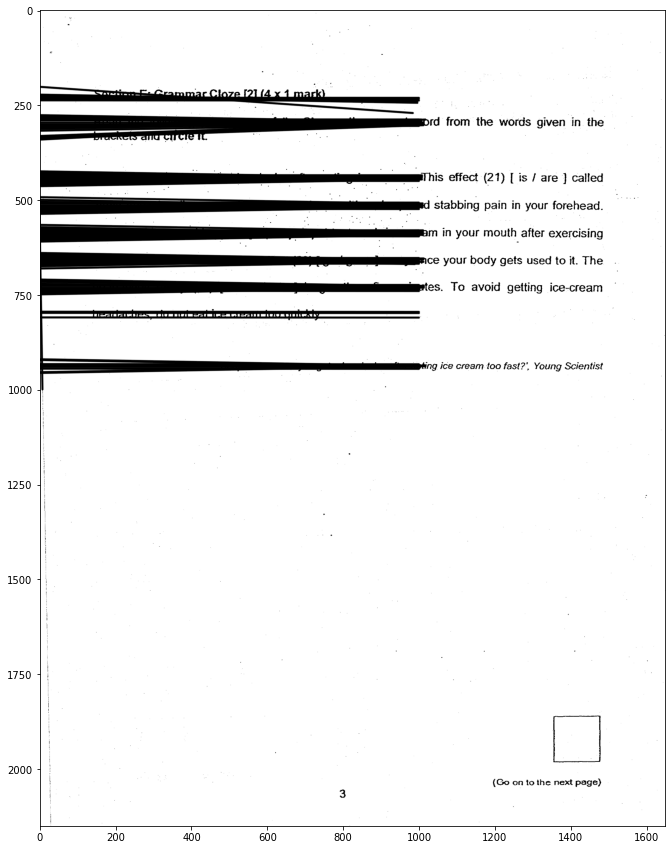

In [201]:
cannied = cv.Canny(binarized, 50, 200, None, 3)
underlay = np.copy(image)

# For ease of view
distance_resolution = 1
angle_resolution = np.pi / 180
vote_threshold = 180
lines = cv.HoughLines(cannied, distance_resolution, angle_resolution, vote_threshold)
skew_angles = []
if lines is not None:
    for line in lines:
        rho = line[0][0]
        theta = line[0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(underlay, pt1, pt2, (0, 0, 0), 3, cv.LINE_AA)
           
        # Assumption that the image is already in protrait with skew angle < 45
        # Get only horizontal lines (i.e Lines with |angle| < 45 from horizontal)
        # Getting other angle of right angled triangle thereby retrieving the deviation angle via congruent alternate internal angles
        dev_from_hrzntal_in_rad = np.pi / 2 - theta 
        
        # Conversion to deg
        dev_from_hrzntal_in_deg = dev_from_hrzntal_in_rad / np.pi * 180
        
        # Assuming dataset skew angle < 10
        if (abs(dev_from_hrzntal_in_deg) < 10):
            skew_angles.append(dev_from_hrzntal_in_deg)
        
# Get average of all horizontal lines angle only
# print(f'All deviation angles: {skew_angles}')
print(f'Number of lines: {len(lines)}')

deskew_angle = sum(skew_angles) / len(skew_angles)
print(f'Deskew Angle: {deskew_angle}')


#plt.imshow(cv.bitwise_not(underlay), cmap="gray")
plt.imshow(cv.cvtColor(underlay, cv.COLOR_BGR2RGB))

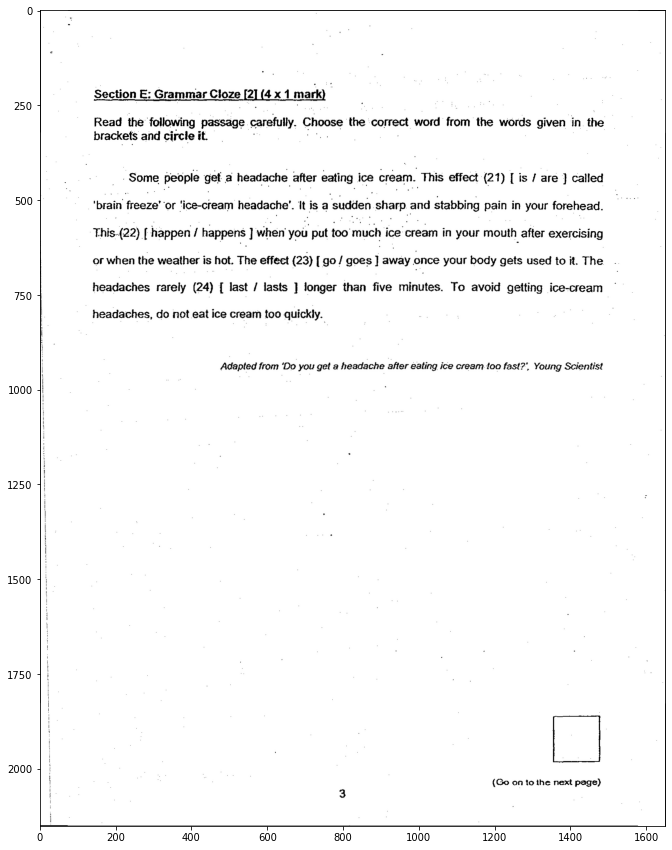

In [203]:
deskewed_image = ndimage.rotate(binarized, -deskew_angle)
plt.imshow(cv.cvtColor(deskewed_image, cv.COLOR_BGR2RGB))

## Noise Removal

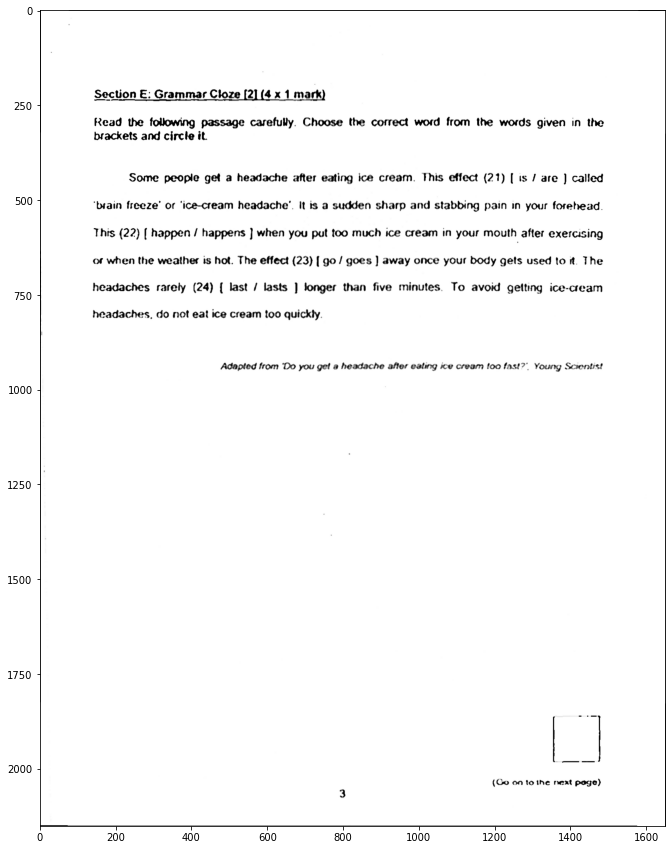

In [204]:
aperture_size = 5
denoised_image = cv.medianBlur(deskewed_image, aperture_size)
plt.imshow(cv.cvtColor(denoised_image, cv.COLOR_BGR2RGB))

## Zoning

### Initial Bounding Rectangles

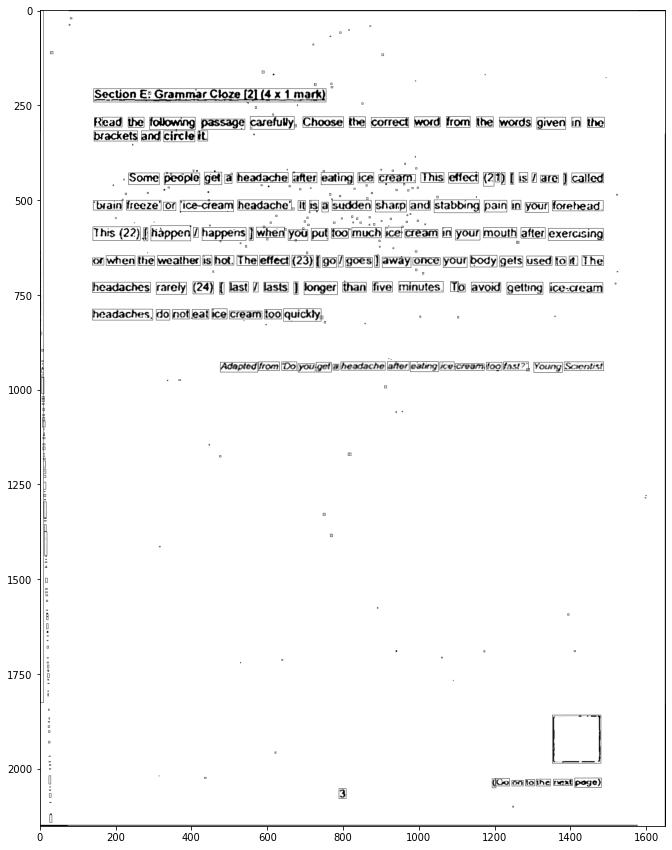

In [205]:
# plt.imshow(cv.cvtColor(denoised_image, cv.COLOR_BGR2RGB))
underlay = np.copy(denoised_image)

contours, hier = cv.findContours(cv.bitwise_not(denoised_image), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
rects = []
for c in contours:
    x, y, w, h = cv.boundingRect(c)
    rects.append((x, y, w, h))
    cv.rectangle(underlay, (x, y), (x + w, y + h), 0, 1)
    
# Sort by x coor
rects.sort(key = lambda x: x[0])
# For removing encapsulating box if there is
rects = list(filter(lambda x: x[0] >= 50 and x[1] >= 50, rects))
plt.imshow(cv.cvtColor(underlay, cv.COLOR_BGR2RGB))


### Final Bounding Rects after Growing

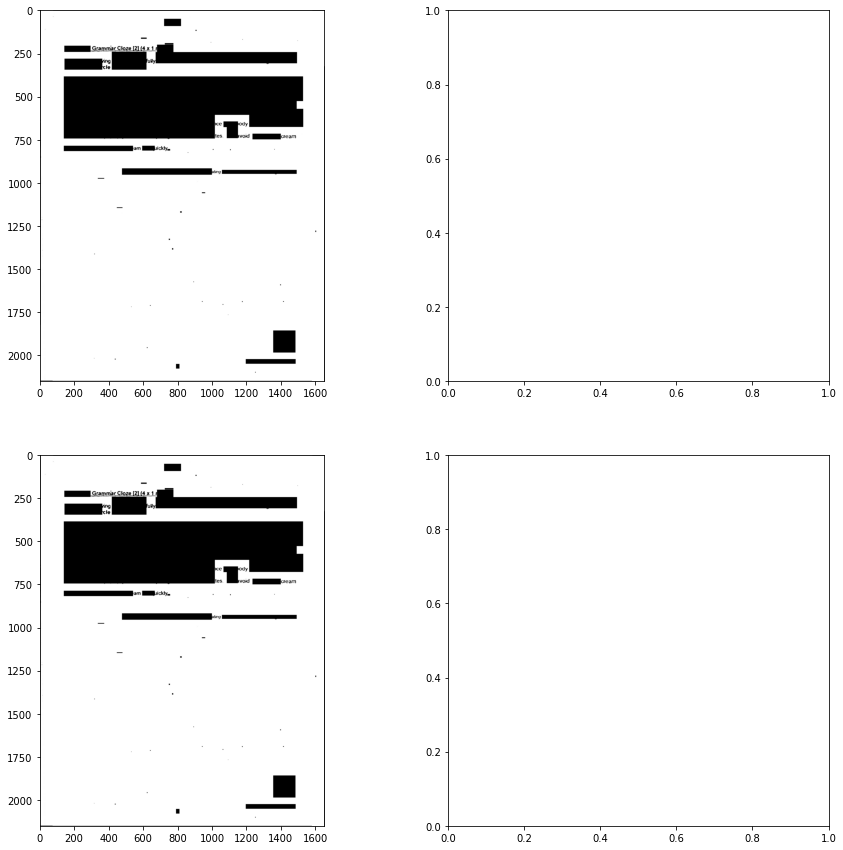

In [206]:
def grow(arr, initial_rects, iteration):
    rects = copy.deepcopy(initial_rects)
    
   
    x_thresh = 50
    y_diff = 50

    final_rects = []

    for i in range(iteration):
        if len(final_rects) != 0:
            rects = copy.deepcopy(final_rects) 
        underlay = np.copy(denoised_image)

        used_rects = [False for rect in rects] 
        final_rects = []
        for index, rect in enumerate(rects):
            if (used_rects[index] == False):
                current_left = rect[0]
                # x + width
                current_right = rect[0] + rect[2]
        
                current_top = rect[1]
                # y + height
                current_bottom = rect[1] + rect[3]

                used_rects[index] = True
        
                # All other rects
                for internal_index, other_rect in enumerate(rects[(index + 1):], start = (index + 1)):
                    
                    other_left = other_rect[0]
                    other_right = other_rect[0] + other_rect[2]
                    other_top = other_rect[1]
                    other_bottom = other_rect[1] + other_rect[3]
                    if ((other_left <= current_right + x_thresh) and (abs(current_top - other_top) <= y_diff or abs(current_bottom - other_bottom) <= y_diff)):
                        current_right = other_right
                        current_top = min(current_top, other_top)
                        current_bottom = max(current_bottom, current_bottom)
                        used_rects[internal_index] = True

                final_rects.append([current_left, current_top, current_right - current_left, current_bottom - current_top])
        for rect in final_rects:
            cv.rectangle(underlay, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), 0, -1)
        arr[i].imshow(cv.cvtColor(underlay, cv.COLOR_BGR2RGB))
    return final_rects
    
underlay = np.copy(denoised_image)
f, arr = plt.subplots(2, 2)
temp = grow(arr[0], rects, 1)
for rect in temp:
    cv.rectangle(underlay, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), 0, -1)

arr[1][0].imshow(cv.cvtColor(underlay, cv.COLOR_BGR2RGB))

### Question Number Detection

 Left most rect: (138, 788, 159, 29)
 Next left most rect: (138, 717, 153, 27)
 Next left most rect: (138, 653, 30, 19)
 Next left most rect: (139, 571, 125, 36)
 Next left most rect: (140, 502, 76, 25)
 Next left most rect: (141, 207, 613, 35)
 Next left most rect: (142, 318, 115, 27)
 Next left most rect: (143, 283, 21, 25)
 Next left most rect: (164, 282, 52, 26)
[(138, 788, 159, 29), (138, 717, 153, 27), (138, 653, 30, 19), (139, 571, 125, 36), (140, 502, 76, 25), (141, 207, 613, 35), (142, 318, 115, 27), (143, 283, 21, 25)]


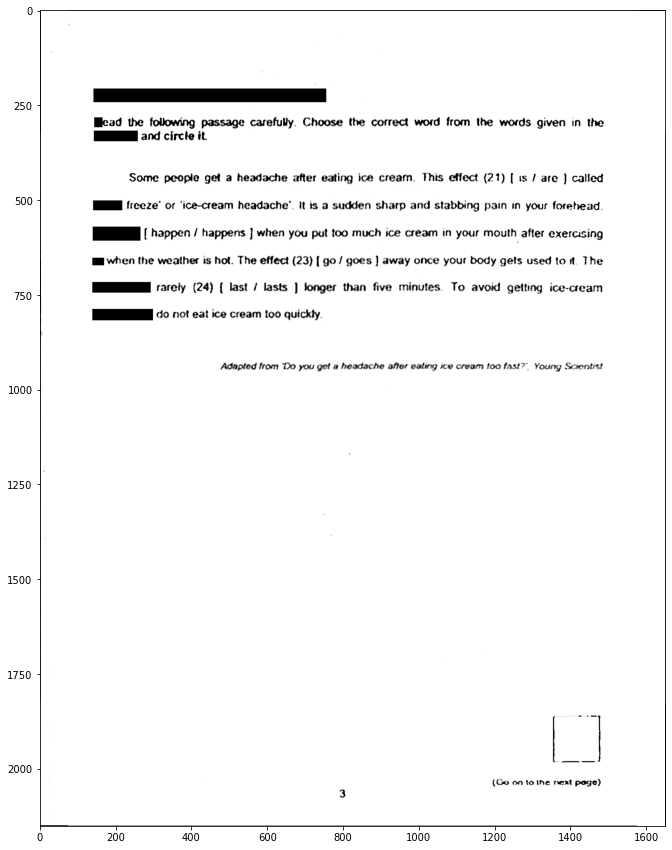

In [207]:
temp_rects = copy.deepcopy(rects)

lowest_x = min(x for (x,y,w,h) in temp_rects if w > 10 and h > 10)
question_num_idx = temp_rects.index([rect for rect in temp_rects if lowest_x in rect][0])
left_most_rect = temp_rects[question_num_idx]
print(f' Left most rect: {left_most_rect}')
del temp_rects[question_num_idx]
question_num_rects = [left_most_rect]
while(True):
    next_lowest_x = min(x for (x,y,w,h) in temp_rects if w > 10 and h > 10)
    next_left_most_rect_idx = temp_rects.index([rect for rect in temp_rects if next_lowest_x in rect][0])
    next_left_most_rect = temp_rects[next_left_most_rect_idx]
    print(f' Next left most rect: {next_left_most_rect}')
    if next_left_most_rect[0] - left_most_rect[0] <= 15:
        del temp_rects[next_left_most_rect_idx]
        question_num_rects.append(next_left_most_rect)
    else:
        break;
        
underlay = np.copy(denoised_image)
print(question_num_rects)
for rect in question_num_rects:
    cv.rectangle(underlay, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), 0, -1)

plt.imshow(cv.cvtColor(underlay, cv.COLOR_BGR2RGB))

### Question Block

Error message: list index out of range


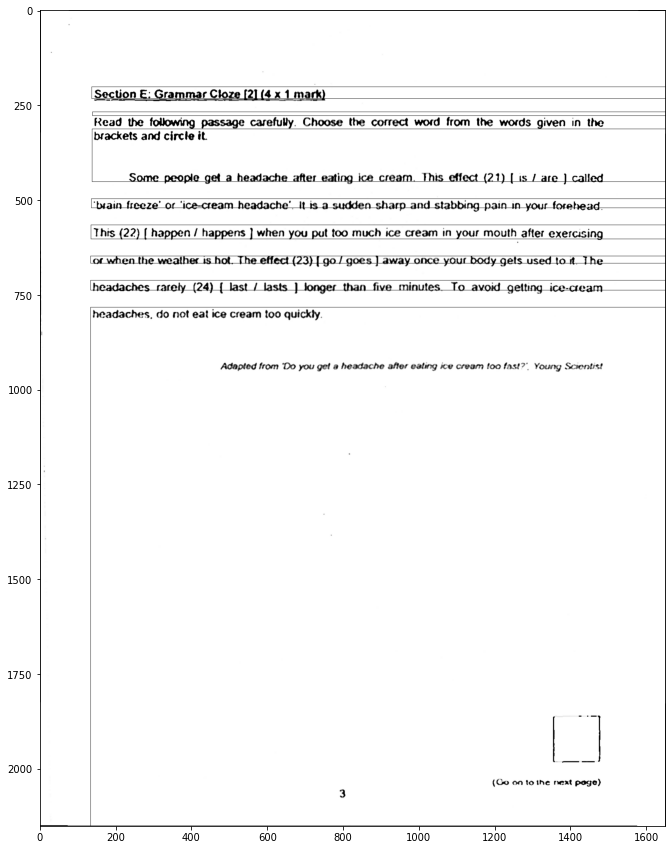

In [208]:
underlay = np.copy(denoised_image)
temp_rects = copy.deepcopy(rects)
highest_x = max(x+w for (x,y,w,h) in temp_rects)
highest_y = max(y+h for (x,y,w,h) in temp_rects)
question_num_rects.sort(key = lambda x: x[1])
question_crops = []
for idx, question_num_rect in enumerate(question_num_rects):
    try:
        next_rect = question_num_rects[idx+1]
    except Exception as e:
        print(f'Error message: {e}')
        cv.rectangle(underlay, (question_num_rect[0] - 5, (question_num_rect[1] - 5)), 
                 (highest_x, highest_y), 0, 1)
        question_crops.append(underlay[(question_num_rect[1] - 5):highest_y, (question_num_rect[0] - 5):highest_x])
        break;
        
    cv.rectangle(underlay, (question_num_rect[0] - 5, question_num_rect[1] - 5), 
            (highest_x, next_rect[1] - 50), 0, 1)
    question_crops.append(underlay[(question_num_rect[1] - 5):(next_rect[1] - 50), (question_num_rect[0] - 5):highest_x])
              
plt.imshow(cv.cvtColor(underlay, cv.COLOR_BGR2RGB))

### Cropped Images

error: OpenCV(4.4.0) /tmp/pip-req-build-99ib2vsi/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


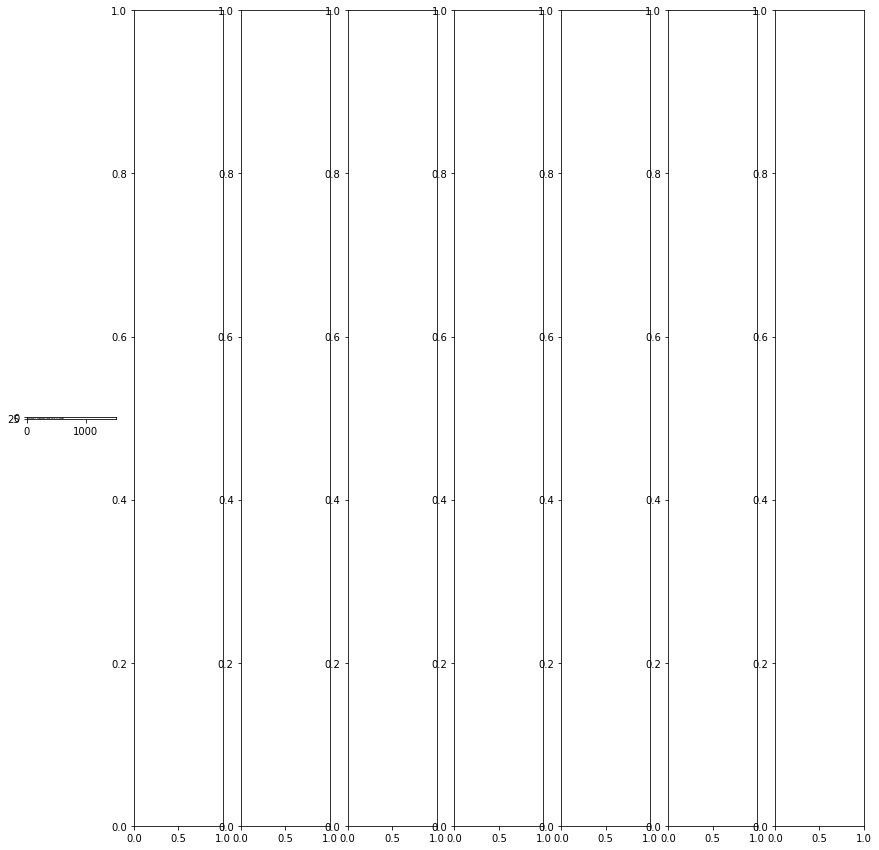

In [209]:
f, arr = plt.subplots(1, len(question_crops))
for idx, question_crop in enumerate(question_crops):
    arr[idx].imshow(cv.cvtColor(question_crop, cv.COLOR_BGR2RGB))